In [23]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [69]:
CLASS_NUM = 3
BATCH_SIZE = 16
EPOCH_STEPS = int(5318/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = r'C:\\Users\\Tri\\Desktop\\preprocessDataSet\\train\\'
IMAGE_TEST=  r'C:\\Users\\Tri\\Desktop\\preprocessDataSet\\test\\'
MODEL_NAME = 'Ygooglenet_stroke2.h5'

In [52]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

generator_main = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
generator_maint = train_datagen.flow_from_directory(
    IMAGE_TEST,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5318 images belonging to 3 classes.
Found 115 images belonging to 1 classes.


In [53]:
def my_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1],data[1],data[1]
        yield x, y

In [57]:
train_generator = my_generator(generator_main)
test_generator=my_generator(generator_maint)

In [37]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [38]:
model = googlenet()

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_118[0][0]']             
 )                                                                                          

In [40]:
optimizer = ['Adam', 'SGD', 'Adam','SGD']
epochs = [5,5,5,5]
history_all = {}

In [41]:
for i in range(len(optimizer)):
    print('Using optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit(
            train_generator,
            steps_per_epoch=EPOCH_STEPS,
            epochs=epochs[i],
            shuffle=True
            )
    if len(history_all) == 0:
            history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
            history_all[key].extend(train_history.history[key])

Using optimizer: Adam, Epoch: 5
Epoch 1/5
332/332 [==============================] - 413s 1s/step - loss: 1.4569 - main_loss: 0.9300 - aux1_loss: 0.8745 - aux2_loss: 0.8817 - main_accuracy: 0.6642 - aux1_accuracy: 0.6636 - aux2_accuracy: 0.6630
Epoch 2/5
332/332 [==============================] - 400s 1s/step - loss: 1.3186 - main_loss: 0.8297 - aux1_loss: 0.8074 - aux2_loss: 0.8224 - main_accuracy: 0.6637 - aux1_accuracy: 0.6677 - aux2_accuracy: 0.6643
Epoch 3/5
332/332 [==============================] - 399s 1s/step - loss: 1.2051 - main_loss: 0.7582 - aux1_loss: 0.7390 - aux2_loss: 0.7507 - main_accuracy: 0.6816 - aux1_accuracy: 0.6931 - aux2_accuracy: 0.6852
Epoch 4/5
332/332 [==============================] - 399s 1s/step - loss: 1.1268 - main_loss: 0.7087 - aux1_loss: 0.6922 - aux2_loss: 0.7016 - main_accuracy: 0.7035 - aux1_accuracy: 0.7175 - aux2_accuracy: 0.7120
Epoch 5/5
332/332 [==============================] - 399s 1s/step - loss: 1.0554 - main_loss: 0.6651 - aux1_loss: 0.

In [70]:
model.save(MODEL_NAME)

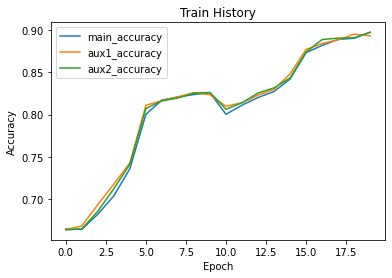

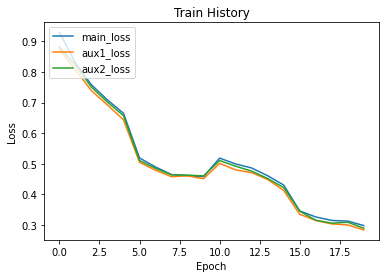

In [43]:
# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))

In [44]:
print(train_history.history.keys())

dict_keys(['loss', 'main_loss', 'aux1_loss', 'aux2_loss', 'main_accuracy', 'aux1_accuracy', 'aux2_accuracy'])


In [45]:
from keras.models import load_model
classifier=load_model('Ygooglenet_stroke2.h15')

In [59]:
from keras.preprocessing.image import ImageDataGenerator
path='C:\\Users\\Tri\\Desktop\\preprocessDataSet\\'
test_data_dir=path+'test\\'
test_datagen=ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 115 images belonging to 1 classes.


In [67]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)
print(predicted_class_indices)

C:\Users\Tri\AppData\Local\Temp/ipykernel_16108/3127084481.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)


8/8 [==============================] - 2s 205ms/step
[[ 0  0 51]
 [ 0  0  0]
 [ 0  0  0]]


In [71]:
import pandas as pd
results_df1 = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df1['id'] = results_df1.id.str.extract('(\d+)')
results_df1['id'] = pd.to_numeric(results_df1['id'], errors = 'coerce')
results_df1.sort_values(by='id', inplace = True)

results_df1.to_csv("GoogLeNetPredict.csv", index=False)
results_df1.head()

ValueError: Data must be 1-dimensional

In [ ]:
df=pd.read_csv('GoogLeNetPredict.csv')
df

In [ ]:
df1=pd.read_csv('truthFile.csv')
df1

In [ ]:
tahmin=df['label']
tahmin

In [ ]:
orijinal=df1['label']
orijinal

In [ ]:
class_names=["0","1","2"]

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(orijinal, predicted_class_indices, target_names=class_names))

print(confusion_matrix(orijinal, predicted_class_indices))

NameError: name 'orijinal' is not defined